# Image Gradients

In [1]:
# As usual, a bit of setup

import time, os, json
import numpy as np
import skimage.io
import matplotlib.pyplot as plt

from cs231n.classifiers.pretrained_cnn import PretrainedCNN
from cs231n.data_utils import load_tiny_imagenet
from cs231n.image_utils import blur_image, deprocess_image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Introducing TinyImageNet

In [2]:
data = load_tiny_imagenet('cs231n/datasets/tiny-imagenet-100-A', subtract_mean=True)

loading training data for synset 20 / 100
loading training data for synset 40 / 100
loading training data for synset 60 / 100
loading training data for synset 80 / 100
loading training data for synset 100 / 100


In [24]:
for i, names in enumerate(data['class_names']):
    print(i, ' '.join('"%s"' % name for name in names))

0 "Egyptian cat"
1 "reel"
2 "volleyball"
3 "rocking chair" "rocker"
4 "lemon"
5 "bullfrog" "Rana catesbeiana"
6 "basketball"
7 "cliff" "drop" "drop-off"
8 "espresso"
9 "plunger" "plumber's helper"
10 "parking meter"
11 "German shepherd" "German shepherd dog" "German police dog" "alsatian"
12 "dining table" "board"
13 "monarch" "monarch butterfly" "milkweed butterfly" "Danaus plexippus"
14 "brown bear" "bruin" "Ursus arctos"
15 "school bus"
16 "pizza" "pizza pie"
17 "guinea pig" "Cavia cobaya"
18 "umbrella"
19 "organ" "pipe organ"
20 "oboe" "hautboy" "hautbois"
21 "maypole"
22 "goldfish" "Carassius auratus"
23 "potpie"
24 "hourglass"
25 "seashore" "coast" "seacoast" "sea-coast"
26 "computer keyboard" "keypad"
27 "Arabian camel" "dromedary" "Camelus dromedarius"
28 "ice cream" "icecream"
29 "nail"
30 "space heater"
31 "cardigan"
32 "baboon"
33 "snail"
34 "coral reef"
35 "albatross" "mollymawk"
36 "spider web" "spider's web"
37 "sea cucumber" "holothurian"
38 "backpack" "back pack" "knaps

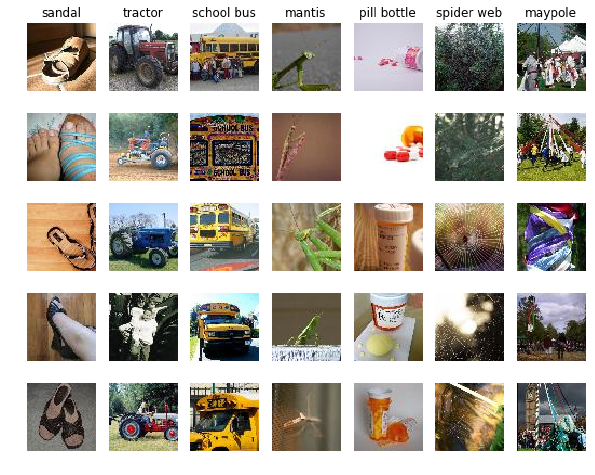

In [3]:
# Visualize some examples of the training data
classes_to_show = 7
examples_per_class = 5

class_idxs = np.random.choice(len(data['class_names']), size=classes_to_show, replace=False)
for i, class_idx in enumerate(class_idxs):
    train_idxs, = np.nonzero(data['y_train'] == class_idx)
    train_idxs = np.random.choice(train_idxs, size=examples_per_class, replace=False)
    for j, train_idx in enumerate(train_idxs):
        img = deprocess_image(data['x_train'][train_idx], data['mean_image'])
        plt.subplot(examples_per_class, classes_to_show, 1 + i + classes_to_show * j)
        if j == 0:
            plt.title(data['class_names'][class_idx][0])
        plt.imshow(img)
        plt.gca().axis('off')

plt.show()

## Pretrained model

In [6]:
model = PretrainedCNN(h5_file = 'cs231n/datasets/pretrained_model.h5')

In [8]:
batch_size = 100

# Test the model on training data
mask = np.random.randint(data['x_train'].shape[0], size=batch_size)
x, y = data['x_train'][mask], data['y_train'][mask]
y_pred = model.loss(x).argmax(axis=1)
print('Training accuracy: ', (y_pred == y).mean())

# Test the model on validation data
mask = np.random.randint(data['x_val'].shape[0], size=batch_size)
x, y = data['x_val'][mask], data['y_val'][mask]
y_pred = model.loss(x).argmax(axis=1)
print('Validation accuracy: ', (y_pred == y).mean())

Training accuracy:  0.92
Validation accuracy:  0.57


## Saliency Maps

In [54]:
def compute_saliency_maps(x, y, model):
    """
    Compute a class saliency map using the model for images x and labels y.
    
    Inputs:
    - x: Input images, of shape (N, 3, H, W);
    - y: Labels for x, of shape (N, );
    - model: A pretrained CNN that will be used to compute the saliency map.
    
    Returns:
    - saliency: An array of shape (N, H, W) giving the saliency maps for the input images.
    """
    N, C, H, W = x.shape
    scores, cache = model.forward(x)
    
    dscores = np.zeros_like(scores)
    dscores[np.arange(N), y] = 1.0
    dx, grads = model.backward(dscores, cache)
    
    saliency = np.sum(abs(dx), axis = 1)
    
    return saliency

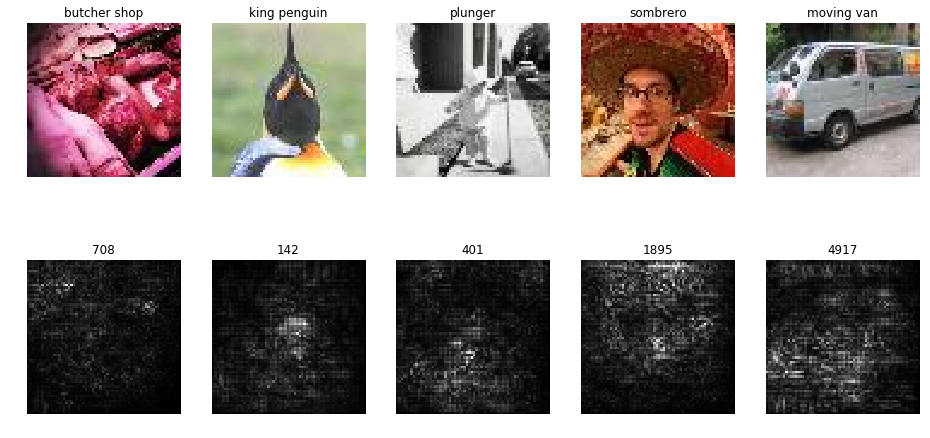

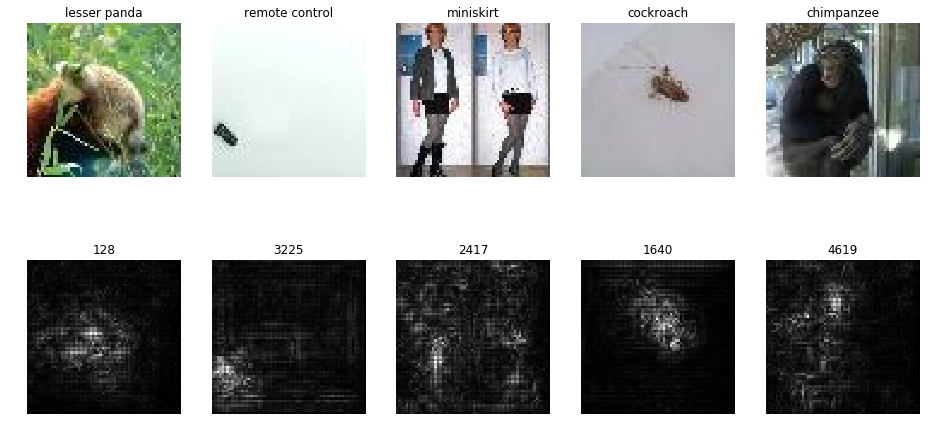

In [56]:
def show_saliency_maps(mask):
    mask = np.asarray(mask)
    x = data['x_val'][mask]
    y = data['y_val'][mask]
    
    saliency = compute_saliency_maps(x, y, model)
    
    for i in range(mask.size):
        plt.subplot(2, mask.size, i + 1)
        plt.imshow(deprocess_image(x[i], data['mean_image']))
        plt.axis('off')
        plt.title(data['class_names'][y[i]][0])
        plt.subplot(2, mask.size, mask.size + i + 1)
        plt.title(mask[i])
        plt.imshow(saliency[i])
        plt.axis('off')
    plt.gcf().set_size_inches(16, 8)
    plt.show()

# Show some random images
mask = np.random.randint(data['x_val'].shape[0], size = 5)
show_saliency_maps(mask)
  
# These are some cherry-picked images that should give good results
show_saliency_maps([128, 3225, 2417, 1640, 4619])

## Fooling Images

In [112]:
from cs231n.layers import *
def make_fooling_image(x, target_y, model):
    """
    Generate a folling image that is close to x, but that the model classifies as target_y.
    
    Inputs:
    - x: Input image, of shape (1, 3, 64, 64);
    - target_y: An integer in the range [0, 100);
    - model: A PretrainedCNN.
    
    Returns:
    - x_fooling: An image that is close to x, but that is classified as target_y by the model.
    """
    x_fooling = x.copy()
    iter = 0
    predict_y = 101
    while predict_y != target_y:
        if iter > 200:
            break
        scores, cache = model.forward(x_fooling)
        predict_y = np.argmax(scores[0])
        
        _, dscores = softmax_loss(scores, target_y)
        #dscores[np.arange(N), target_y] = 1.0
        dx, _ = model.backward(dscores, cache)
        x_fooling -= 500 * dx
        
        print("Iteration: %d, target: %d, predict: %d" % (iter + 1, target_y, predict_y))
        iter += 1
    
    return x_fooling

Iteration: 1, target: 71, predict: 22
Iteration: 2, target: 71, predict: 22
Iteration: 3, target: 71, predict: 22
Iteration: 4, target: 71, predict: 22
Iteration: 5, target: 71, predict: 22
Iteration: 6, target: 71, predict: 22
Iteration: 7, target: 71, predict: 22
Iteration: 8, target: 71, predict: 22
Iteration: 9, target: 71, predict: 22
Iteration: 10, target: 71, predict: 22
Iteration: 11, target: 71, predict: 22
Iteration: 12, target: 71, predict: 22
Iteration: 13, target: 71, predict: 22
Iteration: 14, target: 71, predict: 22
Iteration: 15, target: 71, predict: 22
Iteration: 16, target: 71, predict: 22
Iteration: 17, target: 71, predict: 22
Iteration: 18, target: 71, predict: 22
Iteration: 19, target: 71, predict: 22
Iteration: 20, target: 71, predict: 22
Iteration: 21, target: 71, predict: 22
Iteration: 22, target: 71, predict: 22
Iteration: 23, target: 71, predict: 22
Iteration: 24, target: 71, predict: 28
Iteration: 25, target: 71, predict: 28
Iteration: 26, target: 71, predict

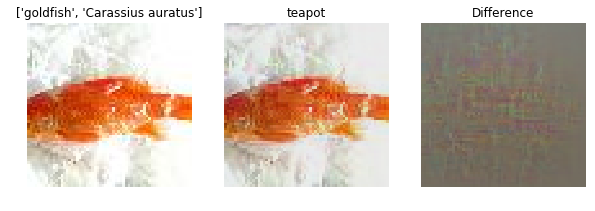

In [117]:
# Find a correctly classified validation image
while True:
    i = np.random.randint(data['x_val'].shape[0])
    x = data['x_val'][i:i+1]
    y = data['y_val'][i:i+1]
    y_pred = model.loss(x)[0].argmax()
    if y_pred == y: break

target_y = 71
x_fooling = make_fooling_image(x, target_y, model)

# Make sure that X_fooling is classified as y_target
scores = model.loss(x_fooling)
assert scores[0].argmax() == target_y, 'The network is not fooled!'

# Show original image, fooling image, and difference
plt.subplot(1, 3, 1)
plt.imshow(deprocess_image(x, data['mean_image']))
plt.axis('off')
plt.title(data['class_names'][y[0]])
plt.subplot(1, 3, 2)
plt.imshow(deprocess_image(x_fooling, data['mean_image'], renorm=True))
plt.title(data['class_names'][target_y][0])
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('Difference')
plt.imshow(deprocess_image(x - x_fooling, data['mean_image']))
plt.axis('off')
plt.show()